# Demonstation of the general optimisation problem
which allows for users to specify the combination of assets to be optimised and the relative weights/cost on each
weird combinations/specifications may give weird results (enjoy)

Get stuff ready for optimisation problem
- Load trip data
- specify bus parameters
- predict energy consumption on trips

In [1]:
import pandas as pd
from RouteZero.models import LinearRegressionAbdelatyModel
from RouteZero.bus import Bus as Ebus

trips_data = pd.read_csv('../data/gtfs/leichhardt/trip_data.csv')
trips_data['passengers'] = 38

max_passengers = 70
battery_capacity = 400      # kWh
charging_rate = 200         # kW
gross_mass = 18000          # kg

# default parameters that they could optionally change
charging_efficiency=0.9
end_of_life_cap=0.8

bus = Ebus(max_passengers, battery_capacity, charging_rate, gross_mass,
              charging_efficiency=charging_efficiency, end_of_life_cap=end_of_life_cap)


model = LinearRegressionAbdelatyModel()
ec_km, ec_total = model.predict_worst_temp(trips_data, bus)


Some default parameters that we may wish to adjust

In [2]:
deadhead = 0.1  # percent [0-1]
resolution = 10  # mins
min_charge_time = 1 * 60  # mins
reserve = 0.2  # percent of all battery to keep in reserve [0-1]

Start specifying the assets we wish to consider and which ones we would like to optimise
First, set the grid limit or choose to optimise it

If set to 'optim' attempts to minimise the grid limit using the relative weighting of Q

In [3]:
grid_limit = 'optim'
# grid_limit = 3500
Q = 100    # relative cost on grid limit, set to 0 if no cost

Specify charger sets, this is done as a list of powers, numbers, and costs,
where number[i] is the number of chargers with power[i] and can be set to 'optim' to allow this to be optimised, in
which case cost[i] is the relative cost on that number.
All lists must be same length, so cost is provided even if not optimised (will be ignored)

If set to 'optim' attempts to minimise the number using the relative weighting of 'cost'

In [4]:
chargers = {'power': [40, 80, 150], 'number': ["optim", 10, "optim"], 'cost': [1, 5, 10]}

Specify battery if we would like to include one, if no battery set to None. If we would like to optimise the battery capacity, then set to 'optim'. 'cost' is the relative weighting on the battery capacity. 'cost' must be provided either way.

If set to 'optim' attempts to minimise the capacity using the relative weighting of 'cost'

In [5]:
# battery = {'power':1000, 'capacity':3000, 'efficiency':0.95, 'cost':10}
battery = {'power':1000, 'capacity':'optim', 'efficiency':0.95, 'cost':10}
# battery = None

Specify a priority on keeping the bus batteries charged at all times. Priority specified by R.

Note, this cost conflicts with the others as it attempts to maximise the battery charge (i.e. acts against other objectives). Hence teh relative weighting of R with respect to the other weightings/costs will greatly impact the results and there will be a fine line between it doing nothing and overridign the other objectives.

In [ ]:
R = 0       # priority on bus charge

Specified allowed times of day to charge (which hours), default is all

In [ ]:
windows = [1]*7 + [1]*3 + [1]*5 + [1]*5 + [1]*4     # all times ok
# windows = [1]*7 + [0]*3 + [1]*5 + [0]*5 + [1]*4     # peak times not allowed

Set up the problem and optimise

In [7]:
from RouteZero.optim import General_problem

problem = General_problem(trips_data, ec_total, bus, chargers, grid_limit=grid_limit, Q=Q, R=R, start_charge=0.9,
                          final_charge=0.8,
                                  deadhead=deadhead,resolution=resolution, min_charge_time=min_charge_time, reserve=reserve,
                                  battery=battery)

In [8]:
import time
t1 = time.time()
results = problem.solve()
t2 = time.time()

print('Solve took {} seconds'.format(t2 - t1))

Solve took 76.82126522064209 seconds


Minimum grid connection power rating is optim kW
Optimised charger configuration is: 
{'power': [150, 80, 40], 'number': array([22., 10.,  0.]), 'cost': [10, 5, 1]}
Unable to achieve desired final charge by 0.0 %


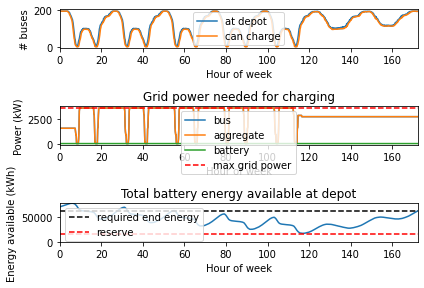

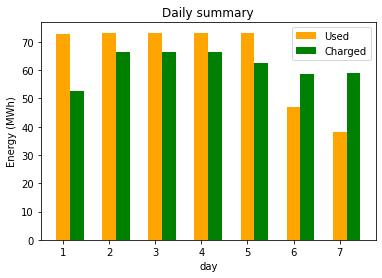

In [9]:
from RouteZero.optim import plot_results
chargers = results['chargers']
charging_power = results['charging_power']
total_energy_avail = results['total_energy_available']
battery_soc = results['battery_soc']
aggregate_power = results['aggregate_power']
battery_power = results['battery_action']
times = problem.times

print('Minimum grid connection power rating is {} kW'.format(grid_limit))
print('Optimised charger configuration is: ')
print(chargers)
print('Unable to achieve desired final charge by {} %'.format(results['final_soc_infeas_%']))

plot_results(results, problem)